In [1]:
# !git clone https://github.com/shreyas-bk/U-2-Net

import os    
import sys
sys.path.append('./U-2-Net')

In [2]:
# !git clone https://github.com/mihaluck/cocoapi.git
import sys
sys.path.append('./cocoapi')

In [3]:
from pycocotools.coco import COCO
import requests

# instantiate COCO specifying the annotations json path
coco = COCO('annotations/instances_val2017.json')
# Specify a list of category names of interest
catIds = coco.getCatIds(catNms=['person'])
# Get the corresponding image ids and images using loadImgs
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=1.53s)
creating index...
index created!


In [ ]:
if not os.path.isdir("coco_person"):
     os.mkdir("coco_person")

In [4]:
# Save the images into a local folder
for im in images[:100]:
    img_data = requests.get(im['coco_url']).content
    with open('coco_person/' + im['file_name'], 'wb') as handler:
        handler.write(img_data)

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from data_loader import RescaleT
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset
from model import U2NET 
from model import U2NETP 

from IPython.display import display
from PIL import Image as Img

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

## 1. TAKE CANDIDATES FOR BACKGROUND REMOVAL

In [7]:
import json
from pandas.io.json import json_normalize
with open('annotations/instances_val2017.json') as f:
    d = json.load(f)

In [8]:
train_df = pd.json_normalize(d , "images")
train_df

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,4,000000397133.jpg,http://images.cocodataset.org/val2017/00000039...,427,640,2013-11-14 17:02:52,http://farm7.staticflickr.com/6116/6255196340_...,397133
1,1,000000037777.jpg,http://images.cocodataset.org/val2017/00000003...,230,352,2013-11-14 20:55:31,http://farm9.staticflickr.com/8429/7839199426_...,37777
2,4,000000252219.jpg,http://images.cocodataset.org/val2017/00000025...,428,640,2013-11-14 22:32:02,http://farm4.staticflickr.com/3446/3232237447_...,252219
3,1,000000087038.jpg,http://images.cocodataset.org/val2017/00000008...,480,640,2013-11-14 23:11:37,http://farm8.staticflickr.com/7355/8825114508_...,87038
4,6,000000174482.jpg,http://images.cocodataset.org/val2017/00000017...,388,640,2013-11-14 23:16:55,http://farm8.staticflickr.com/7020/6478877255_...,174482
...,...,...,...,...,...,...,...,...
4995,3,000000512403.jpg,http://images.cocodataset.org/val2017/00000051...,640,529,2013-11-24 05:12:53,http://farm1.staticflickr.com/143/350452845_fa...,512403
4996,4,000000168974.jpg,http://images.cocodataset.org/val2017/00000016...,500,375,2013-11-24 07:19:48,http://farm3.staticflickr.com/2360/2063838083_...,168974
4997,1,000000552775.jpg,http://images.cocodataset.org/val2017/00000055...,500,375,2013-11-24 10:38:31,http://farm4.staticflickr.com/3136/3106037881_...,552775
4998,3,000000394940.jpg,http://images.cocodataset.org/val2017/00000039...,640,426,2013-11-24 13:47:05,http://farm9.staticflickr.com/8227/8566023505_...,394940


In [9]:
input_path = "coco_person"

root_in = 'fiftyone/coco-2017'
root_out = './'# root_out give the folder direciton of after-processed images, csv..

In [10]:
if not os.path.isdir("subtraction_train"):
     os.mkdir("subtraction_train")
if not os.path.isdir("subtraction_test"):
     os.mkdir("subtraction_test")

In [11]:
paths = [file for file in train_df[:100].file_name]
img_to_draw = [input_path + '/' + file for file in train_df[:100].file_name]

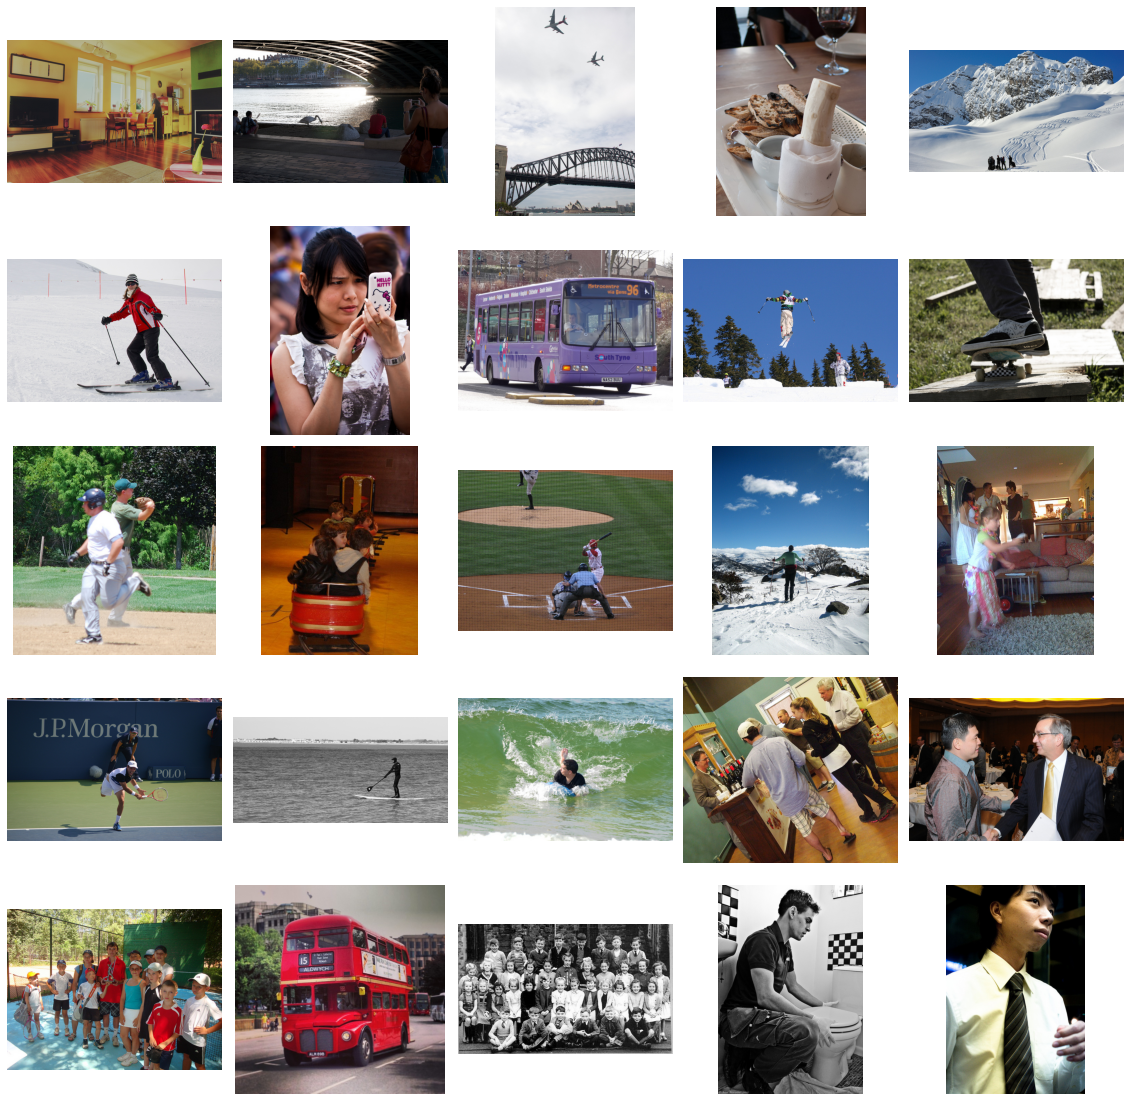

In [13]:
import os
fig, axes = plt.subplots(5, 5, figsize=(20,20))

for idx, img in enumerate(os.listdir('coco_person')[0:25]):
    i = idx % 5 
    j = idx // 5
    image = Img.open('coco_person/'+img)
    iar_shp = np.array(image).shape
    axes[i, j].axis('off')
    axes[i, j].imshow(image)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## 2. Use CLAHE

**Here we use GPU to process the images**

In [14]:
THRESHOLD = 0.9
BATCH_SIZE = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
def CLAHE_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(24,32))
    img = np.asarray(origin_input['image'])
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img[:,:,-1] = clahe.apply(img[:,:,-1])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    
    return {'imidx':imidx, 'image':img,'label':label}

def BilateralFilter_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    img = np.asarray(origin_input['image'])
    img = cv.bilateralFilter(img,5,75,75)
    
    return {'imidx':imidx, 'image':img,'label':label}

def EqualizeHist_Convert(origin_input):
    imidx = origin_input['imidx']
    label = origin_input['label']
    img = np.asarray(origin_input['image'])
    img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img[:,:,-1] = cv.equalizeHist(img[:,:,-1])
    img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
    
    return {'imidx':imidx, 'image':img,'label':label}

In [16]:
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

In [17]:
def pred_unet_CLAHE(model, imgs, paths, train=False):
    salobj_dataset = SalObjDataset(img_name_list = imgs, lbl_name_list = [], transform = transforms.Compose([CLAHE_Convert, RescaleT(320), ToTensorLab(flag=0)]))
    salobj_dataloader = DataLoader(salobj_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 0)
    
    model.to(DEVICE)
    
    error_log = []
    for i, batch in enumerate(salobj_dataloader):
        model.eval()
        img_batch = batch['image'] # (batch size, channel, row, columns)
        images = img_batch.type(torch.float32) # change torch.double -> torch.float
        images = images.to(DEVICE) 
        with torch.no_grad():
            d1, d2, d3, d4, d5, d6, d7 = model(images)
        
        predict = d5[:,0,:,:]# (batch size, 1, row, columns)
        predict = normPRED(predict)

        del d1, d2, d3, d4, d5, d6, d7

        predict = predict.squeeze()# (batch size, row, columns)
        predict_np = predict.cpu().numpy()

        # Masked image - using threshold you can soften/sharpen mask boundaries
        predict_np[predict_np > THRESHOLD] = 1
        predict_np[predict_np <= THRESHOLD] = 0

        for j in range(len(predict_np)):
            file = paths[i * BATCH_SIZE + j]
            mask_np = predict_np[j]
            mask = Img.fromarray(mask_np*255).convert('RGB')
            image = Img.open(imgs[i * BATCH_SIZE + j])
            mask = mask.resize((image.width, image.height), resample=Img.BILINEAR)
            back = Img.new("RGB", (image.width, image.height), (255, 255, 255)) # WHITE Backgroud
            mask = mask.convert('L')
            im_out = Img.composite(image, back, mask)
            
            mask_rs = np.array(mask)
            
            x,y,w,h = cv.boundingRect (mask_rs)
            ymin = y
            ymax = y + h
            xmin = x
            xmax = x + w
            
            #used to sift invalid image by the "1"(white) area / rectangle area(white and black)
            if (x,y,w,h) == (0,0,0,0) or (((mask_rs != 0).sum()) / (w * h)) < 0.2:
                crop_img = np.array(image)
                error_log.append(file)
                print('Failed:\t', file)
            else:
                im_out_np = np.array(im_out)
                crop_img = im_out_np#[ymin:ymax, xmin:xmax]
                #crop_img = cv.resize(crop_img, (im_out_np.shape[0], im_out_np.shape[1]), interpolation = cv.INTER_AREA)
            if train:
                cv.imwrite(os.path.join(root_out, 'subtraction_train', file), crop_img)
            else:
                cv.imwrite(os.path.join(root_out, 'subtraction_test', file), crop_img)
    if train:
        pd.DataFrame({'image':error_log}).to_csv(os.path.join(root_out, 'Ignorance_Train_Img.csv'))
    else:
        pd.DataFrame({'image':error_log}).to_csv(os.path.join(root_out, 'Ignorance_Test_Img.csv'))

In [18]:
UNET2_SMALL = True

In [19]:
%%capture

if UNET2_SMALL:
    model_dir = "U-2-Net/u2netp.pth"  # Faster ... a lot (!) but less accurate
    net = U2NETP(3,1) 
else:
    model_dir = "U-2-Net/u2net.pth"
    net = U2NET(3,1) 


if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:        
    net.load_state_dict(torch.load(model_dir, map_location=torch.device("cpu")))

net.eval()

## 3. TRANSFORM & WRITE and U2-Net RESULT VISUALIZATION

Let's use parameter ***train*** to indicate that we are select and process the images from train or test images

In [28]:
# Transform and write Train images
input_path = "coco_person"
paths = [file for file in os.listdir('coco_person')[:80]]
img_to_draw = [input_path + '/' + file for file in os.listdir('coco_person')[:80]]
pred_unet_CLAHE(net, img_to_draw, paths, train=True)

C:\Users\mihail\AppData\Local\Temp\ipykernel_10372\1718886796.py:33: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  mask = mask.resize((image.width, image.height), resample=Img.BILINEAR)


Failed:	 000000000139.jpg
Failed:	 000000001268.jpg
Failed:	 000000001490.jpg
Failed:	 000000001761.jpg
Failed:	 000000012120.jpg
Failed:	 000000012280.jpg


In [22]:
# # Transform and write Train images
# input_path = "coco_person"
# paths = [file for file in X_train.file_name]
# img_to_draw = [input_path + '/' + file for file in X_train.file_name]
# pred_unet_CLAHE(net, img_to_draw, paths, train=True)

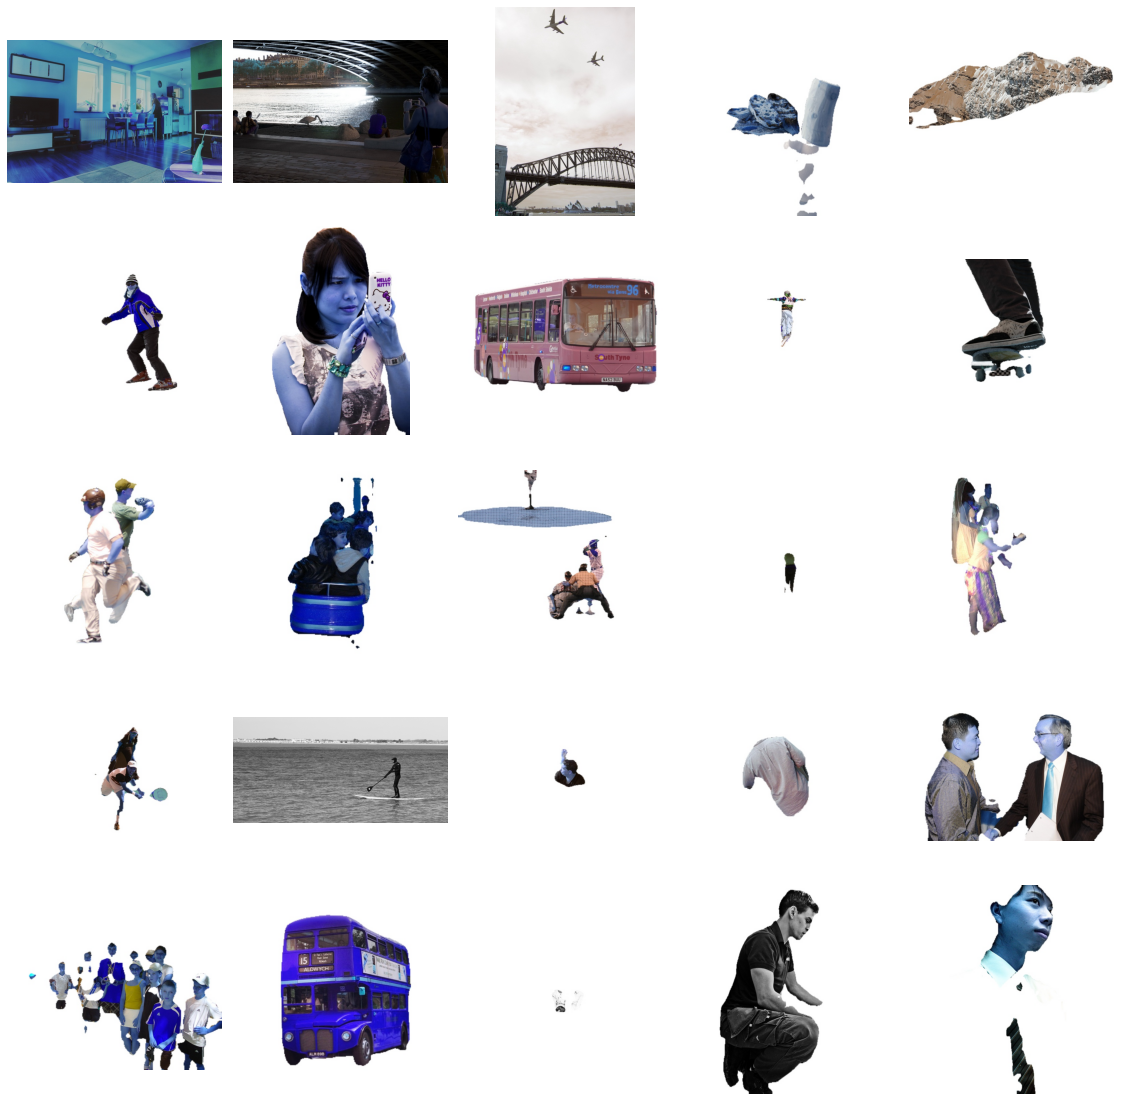

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(20,20))

for idx, img in enumerate(img_to_draw[0:25]):
    i = idx % 5 
    j = idx // 5
    image = Img.open(img)
    iar_shp = np.array(image).shape
    axes[i, j].axis('off')
    axes[i, j].imshow(image)
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [23]:
# Transform and write Test images
input_path = "coco_person"
paths = [file for file in os.listdir('coco_person')[80:100]]
img_to_draw = [input_path + '/' + file for file in os.listdir('coco_person')[80:100]]
pred_unet_CLAHE(net, img_to_draw, paths, train=False)

C:\Users\mihail\AppData\Local\Temp\ipykernel_10372\1718886796.py:33: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  mask = mask.resize((image.width, image.height), resample=Img.BILINEAR)


Failed:	 000000026690.jpg
